In [114]:
import numpy as np
from scipy.integrate import quad, dblquad
from scipy.optimize import minimize, minimize_scalar
from scipy.special import hyp2f1

import numba
from numba.types import intc, CPointer, float64
from scipy import LowLevelCallable

import os
import time

colors = [c.values()[0] for c in list(plt.rcParams["axes.prop_cycle"])]

To-do:
* Unsure about factors of 2 in $e^- + e^+$ fluxes...

## Setup

### Constants

In [115]:
speed_of_light = 3.0e10  # cm / s
kpc_to_cm = 3.086e21  # 1 kpc = 3.086 x 10^21 cm

b0 = 1.0e-16  # GeV/s
e0 = 1.  # GeV

D0 = 1.0e28  # cm^2 / s
delta = 0.7

alpha_em = 1. / 137.
me = 0.501 * 1e-3  # m_e (GeV)
fermi_psf = 0.15 * np.pi / 180.  # arxiv:0902.1089
fermi_psf_solid_angle = 2.*np.pi*(1. - np.cos(fermi_psf))

### Load AMS-02, DAMPE data + plotting fns

In [116]:
pos_frac_es, pos_frac = np.loadtxt("../data/fluxes/positron_fraction_ams.dat").T[[0, 3]]

ams_es, ams_bin_low, ams_bin_high, ams_dflux, ams_stat, ams_syst = np.loadtxt("../data/fluxes/electron_positron_flux_ams.dat").T
ams_dflux = ams_dflux * 1e-4
ams_dflux_err = np.sqrt(ams_stat**2 + ams_syst**2) * 1e-4

dampe_bin_low, dampe_bin_high, dampe_es, dampe_dflux, dampe_stat, dampe_syst = np.loadtxt("../data/fluxes/electron_positron_flux_dampe.dat").T
dampe_dflux = dampe_dflux * 1e-4
dampe_bins = np.transpose([dampe_bin_low, dampe_bin_high])
dampe_dflux_err = np.sqrt(dampe_stat**2 + dampe_syst**2) * 1e-4

ams_aniso_bound = 0.036

dampe_excess_bin_low, dampe_excess_bin_high = 1318.3, 1513.6
dampe_excess_iflux = (dampe_excess_bin_high - dampe_excess_bin_low) * dampe_dflux[np.abs(dampe_es-1400.).argmin()]  # integrated flux in "excess" cm^-2 s^-1 sr^-1

In [117]:
def plot_obs_helper(bin_ls, bin_rs, vals, errs, label=None, color="r", alpha=0.75, lw=0.75):
    for i, (bl, br, l, u) in enumerate(zip(bin_ls, bin_rs, vals-errs, vals+errs)):
        if i != len(bin_ls) - 1:
            plt.fill_between([bl, br], [l, l], [u, u], color=color, alpha=alpha, lw=lw)
        else:
            plt.fill_between([bl, br], [l, l], [u, u], color=color, alpha=alpha, lw=lw, label=label)

In [118]:
def plot_obs(power, highlight_excess_bins=True):
    # Observations
    plot_obs_helper(dampe_bin_low, dampe_bin_high,
                    dampe_es**power * dampe_dflux,
                    dampe_es**power * dampe_dflux_err,
                    label="DAMPE", alpha=0.3, lw=0.5, color="y")

    if highlight_excess_bins:
        excess_idxs = range(23, 28) + [29]
        plot_obs_helper(dampe_bin_low[excess_idxs], dampe_bin_high[excess_idxs],
                        dampe_es[excess_idxs]**power * dampe_dflux[excess_idxs],
                        dampe_es[excess_idxs]**power * dampe_dflux_err[excess_idxs],
                        alpha=0.5, lw=0.5, color="g")

In [119]:
y_label = r"$E^%i \frac{d\phi}{dE}|_{e^- + e^+}$ (GeV$^%i$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$)"

In [120]:
def get_color(bg_label):
    bg_labels = ["bg_dampe", "bg_alt"]
    return list(plt.rcParams["axes.prop_cycle"])[bg_labels.index(bg_label)]["color"]

### Background models

In [121]:
def bg_dampe(es):
    phi0 = 1.62e-4 * 1e-4  # (cm^2 s sr GeV)^-1
    eb = 914  # GeV
    gamma1 = 3.09
    gamma2 = 3.92
    delta = 0.1
    
    return phi0 * (100. / es)**gamma1 * (1. + (eb/es)**((gamma1-gamma2)/delta))**(-delta)

def bg_alt(es):
    phi0 = 246.0e-4   # (cm^2 s sr GeV)^-1
    gamma = 3.09
    delta = 10.
    delta_gamma1 = 0.095
    delta_gamma2 = -0.48
    ebr2 = 471.  # GeV
    ebr1 = 50.  # GeV
    
    return phi0 * es**(-gamma) * (1 + (ebr1 / es)**delta)**(delta_gamma1/delta) * \
        (1 + (es/ebr2)**delta)**(delta_gamma2/delta)

### Propagation

Energy losses

In [122]:
def b(e):  # GeV / s
    return b0 * (e / e0)**2

Diffusion

In [123]:
def D(e):  # cm^2 / s
    return D0 * (e / e0)**delta

Timescales. See eq. 5.3 in Stefano's book.

In [124]:
def t_diff(e, d):
    # Diffusion timescale (s)
    return (d*kpc_to_cm)**2 / (D0 * 1400.**delta)

def t_loss(e):
    # Energy loss timescale (s)
    return e / b(e)

# lambda_prop must be less than this quantity
lambda_prop_max = D0 * e0 / (b0 * (1. - delta))  # cm^2

def lambda_prop(es, mx):  # cm^2
    def helper(e):
        return D0*((e/e0)**delta*e0**2*mx - e*e0**2*(mx/e0)**delta) / \
            (b0*e*mx - b0*e*mx*delta) if e < mx else 0.
    
    return np.vectorize(helper)(es)

### Point-like clump

In [125]:
def dphi_de_e_pt(es, d, mx, lum):
    """Differential flux of e^- from a point-like DM clump after propagation.
    
    To-do
    -----
    Include muon, tau final state contributions?
    
    Parameters
    ----------
    e : float
        e^- energy (GeV).
    d : float
        Distance to clump (kpc).
    lum : float
        Clump luminosity (s^-1).
        
    Returns
    -------
    phi_e : float
        Differential flux of e^- from DM annihilating in the clump (GeV^-1 cm^-2 s^-1 sr^-1)
    """
    d_cm = kpc_to_cm * d  # convert distance to cm
    
    def helper(e):
        lam = lambda_prop(e, mx)
        return 1. / b(e) * np.exp(-d_cm**2 / (4.*lam)) / (4.*np.pi*lam)**1.5 * speed_of_light/(4.*np.pi) * lum if e < mx else 0.
    
    return np.vectorize(helper)(es)

def dphi_de_gamma_pt(es, d, mx, lum):
    """Differential photon flux from FSR off xx->e+e- (GeV^-1 cm^-2 s^-1 sr^-1)"""
    d_cm = kpc_to_cm * d
    
    def helper(e):
        if e < mx:
            ecm = 2.*mx
            eps = 2.*me / ecm
            x = 2.*e / ecm
            
            return lum/(4.*np.pi*d_cm**2) * alpha_em/(np.pi*e) * (1 + (1 - x)**2) * (np.log(4.*(1-x) / eps) - 1.)
        else:
            return 0.
    
    return np.vectorize(helper)(es)

def phi_gamma_pt(d, mx, lum, e_thresh=0.1):
    """Flux of gamma rays produced through FSR from xx->e+e- by DM annihilating
    in a point-like clump.
    
    Parameters
    ----------
    e_thresh : float
        Minimum detectable gamma ray energy (GeV). Default is Fermi's threshold.
    d : float
        Distance to clump (kpc).
    lum : float
        Clump luminosity (s^-1).
        
    Returns
    -------
    phi_gamma : float
        Integrated flux of gamma rays from DM annihilating in the clump (cm^-2 s^-1 sr^-1)
    """
    d_cm = kpc_to_cm * d  # convert distance to cm
    return lum / (4.*np.pi*d_cm**2) * 4.*alpha_em/np.pi * np.log(2.*mx/me) * \
        np.log(mx/e_thresh)

In [126]:
def lum_dampe_pt(d, mx, bg_dflux):
    """Returns the luminosity such that xx->e+e- fits the DAMPE excess.
    """
    def integrand(e):
        # Factor of 2 to count e+ and e-
        return 2. * dphi_de_e_pt(e, d, mx, lum=1.)
    
    residual_flux = dampe_excess_iflux - quad(bg_dflux, dampe_excess_bin_low, dampe_excess_bin_high, epsabs=0.)[0]
    return residual_flux / quad(integrand, dampe_excess_bin_low, dampe_excess_bin_high, epsabs=0)[0]

def dphi_de_e_dampe_pt(e, d, bg_dflux):
    """Gets differential electron flux (GeV^-1 cm^-2 s^-1 sr^-1) by fitting the clump luminosity to the DAMPE excess.
    """
    mx = dampe_excess_bin_high  # WARNING: only optimal for d < ~1 kpc!!!
    lum = lum_dampe_pt(d, mx, bg_dflux)
    
    return dphi_de_e_pt(e, d, mx, lum)

def dphi_de_gamma_dampe_pt(e, d, bg_dflux):
    """Gets differential photon flux (GeV^-1 cm^-2 s^-1 sr^-1) corresponding by
    requiring luminosity to be such that xx->e+e- fits the DAMPE excess.
    """
    mx = dampe_excess_bin_high  # WARNING: only optimal for d < ~1 kpc!!!
    lum = lum_dampe_pt(d, mx, bg_dflux)
    
    return dphi_de_gamma_pt(e, d, mx, lum)

def phi_gamma_dampe_pt(d, bg_dflux, e_min=0.1):
    """Gets photon flux (cm^-2 s^-1 sr^-1) corresponding by requiring luminosity
    to be such that xx->e+e- fits the DAMPE excess.
    """
    mx = dampe_excess_bin_high  # WARNING: only optimal for d < ~1 kpc!!!
    lum = lum_dampe_pt(d, mx, bg_dflux)
    
    return phi_gamma_pt(d, mx, lum, e_min)

The constrain functions return True if there exists $m_\chi$ and $\mathcal{L}$ such that the constraint is not violated.

In [127]:
def get_dampe_anisotropy_pt(d, bg_dflux):
    """Gets the e-+e+ anisotropy from a DM clump with luminosity such that xx->e+e- explains the DAMPE excess.
    """
    # Use last AMS-02 measurement, since bg is softer than DM signal
    e = ams_es[-1]
    flux_tot = ams_dflux[-1]
    
    # Find luminosity explaining the DAMPE excess
    mx = dampe_excess_bin_high  # WARNING: only optimal for d < ~1 kpc!!!
    lum = lum_dampe_pt(d, mx, bg_dflux)
    
    # Forward - backward flux. Factor of 2 since we want e-+e+ flux.
    flux_fb = 2*dphi_de_e_pt(e, d, mx, lum)
    
    return flux_fb/flux_tot * 3.*D(e)/speed_of_light * 2.*d*kpc_to_cm / lambda_prop(e, mx)

def constrain_anisotropy_pt(d, bg_dflux):
    aniso = get_dampe_anisotropy_pt(d, bg_dflux)
    if aniso > ams_aniso_bound:
        return False
    else:
        return True

def constrain_ep_e_spec_pt(d, bg_dflux, n_sigma=3., excluded_idxs=[]):
    mx = dampe_excess_bin_high  # WARNING: only optimal for d < ~1 kpc!!!
    lum = lum_dampe_pt(d, mx, bg_dflux)
    idxs = list(set(range(len(dampe_bins))) - set(excluded_idxs))
    
    def integrand(e):
        return 2. * dphi_de_e_pt(e, d, mx, lum)
    
    for (bl, br), dflux, dflux_err in reversed(zip(dampe_bins[idxs],
                                                   dampe_dflux[idxs],
                                                   dampe_dflux_err[idxs])):
        if bl < mx:
            # Get flux from DM annihilations in the bin
            dm_iflux = quad(integrand, bl, br, epsabs=0.)[0]

            # Residual flux
            obs_iflux = (br - bl) * dflux
            bg_iflux = quad(bg_dflux, bl, br, epsabs=0.)[0]
            residual_iflux = obs_iflux - bg_iflux
            
            # Error on integrated flux
            obs_iflux_err = (br - bl) * dflux_err

            if abs(dm_iflux - residual_iflux) / obs_iflux_err >  n_sigma:
                return False
    
    return True

### Non-point-like clump

Put the annihilation plateau in?

In [158]:
@numba.cfunc(float64(intc, CPointer(float64)))
def dphi_de_integrand_cf(n, xx):
    """
    Parameters
    ----------
    r, e, d, mx, rs, rhos, sv, gamma
    """
    # Extract arguments
    r = xx[0]
    e = xx[1]
    d = xx[2]
    mx = xx[3]
    rs = xx[4]
    rhos = xx[5]
    sv = xx[6]
    gamma = xx[7]

    if e > mx:
        return 0.
    else:
        # Constant factor
        fact_const = np.pi*sv / mx**2
        
        # Energy-dependent parts
        b = b0 * (e / e0)**2
        lam = D0 * e0 / (b0 * (1. - delta)) * \
            ((e0 / e)**(1. - delta) - (e0 / mx)**(1. - delta))
        fact_e = 1. / (b * (4.*np.pi*lam)**1.5)
        
        # Term from performing theta integral
        th_term = (rhos**2*rs**2*((d + r)**(2. - 2.*gamma) *
                                  (d + r + rs)**(-5. + 2.*gamma) *
                                  (3.*d**2*(d + r + (5. - 2.*gamma)*rs) + 
                                   6.*d*r*(d + r + (5. - 2.*gamma)*rs) + 
                                   3.*r**2*(d + r + (5. - 2.*gamma)*rs) + 
                                   (10. - 9.*gamma + 2.*gamma**2)*rs**2*
                                   (3.*(d + r) + 3.*rs - 2.*gamma*rs)) + 
                                  np.abs(d - r)**(2. - 2.*gamma) *
                                  (rs + np.abs(d - r))**(-5. + 2.*gamma)*
                                  ((-5. + 2.*gamma)*rs*
                                   (3.*d**2 - 6.*d*r + 3.*r**2 +
                                    (6. - 7.*gamma + 2.*gamma**2)*rs**2) -
                                   3.*(d**2 - 2.*d*r + r**2 + 
                                      (10. - 9.*gamma + 2.*gamma**2)*rs**2) *
                                   np.abs(d - r)))) / \
            (2.*d*(-2. + gamma)*(-1. + gamma)*(-5. + 2.*gamma)*(-3. + 2.*gamma)*r)

        # Term with purely radial dependence
        r_term = r**2 * np.exp(-(r * kpc_to_cm)**2 / (4. * lam))

        # Put it all together
        ret_val = fact_const * fact_e * th_term * r_term * speed_of_light * kpc_to_cm**3
        
        assert ret_val >= 0
        
        return ret_val

dphi_de_integrand = LowLevelCallable(dphi_de_integrand_cf.ctypes)
    
def dphi_de_e(es, d, mx, rs, rhos, sv=3e-26, gamma=0.5):
    """Computes dphi/dE|_{e-} for a DM clump.
    
    Parameters
    ----------
    es : float or float array
        Electron energies, GeV.
    d : float
        Distance to the clump's center, kpc.
    mx : float
        DM mass, GeV.
    rs : float
        Clump scale radius, kpc.
    rhos : float
        Clump density normalization, GeV/cm^3.
    sv : float
        DM self-annihilation cross section, cm^3/s.
    gamma : float
        NFW power index.
    """
    def helper(e):
        if e >= mx:
            return 0.
        else:
            ret_val = quad(dphi_de_integrand, 0, 100.*d,
                           args=(e, d, mx, rs, rhos, sv, gamma),
                           epsabs=0)

            assert ret_val[0] >= 0.
            return ret_val[0]
    
    return np.vectorize(helper)(es)

def rhos_dampe(d, mx, rs, bg_dflux, sv=3e-26, gamma=0.5):
    """Returns the clump density profile normalization that makes xx->e+e- fit
    the DAMPE excess.
    
    Parameters
    ----------
    d : float
        Distance to the clump's center, kpc.
    mx : float
        DM mass, GeV.
    rs : float
        Clump scale radius, kpc.
    sv : float
        DM self-annihilation cross section, cm^3/s.
        
    Returns
    -------
    rhos : float
        Density profile normalization in GeV / cm^3.
    """
    def integrand(e):
        # Factor of 2 to count e+ and e-
        return 2. * dphi_de_e(e, d, mx, rs, rhos=1., sv=sv, gamma=gamma)
    
    # Subtract off background contribution to the excess
    residual_flux = dampe_excess_iflux - quad(bg_dflux,
                                              dampe_excess_bin_low,
                                              dampe_excess_bin_high, epsabs=0.)[0]
    # DM contribution is proportional to rho_s^2
    return np.sqrt(residual_flux / quad(integrand,
                                        dampe_excess_bin_low,
                                        dampe_excess_bin_high, epsabs=0)[0])

def dphi_de_e_dampe(es, d, rs, bg_dflux, sv=3e-26, gamma=0.5):
    """Gets differential electron flux (GeV^-1 cm^-2 s^-1 sr^-1) by fitting rho_s
    to the DAMPE excess.
    """
    mx = dampe_excess_bin_high  # WARNING: only optimal for d < ~1 kpc!!!
    rhos = rhos_dampe(d, mx, rs, bg_dflux, sv, gamma)
    
    return dphi_de_e(es, d, mx, rs, rhos, sv, gamma)

@numba.cfunc(float64(intc, CPointer(float64)))
def J_factor_integrand_cf(n, xx):
    """
    Parameters
    ----------
    r, ctmax, d, rs, rhos, gamma
    """
    # Extract arguments
    r = xx[0]
    ctmax = xx[1]
    d = xx[2]
    rs = xx[3]
    rhos = xx[4]
    gamma = xx[5]

    # Solid angle subtended by target
    dOmega = 2*np.pi*(1.-ctmax)

    th_term = -((d**2 - 2*d*r + r**2)**(1 - gamma)*rs**2*
                (np.sqrt(d**2 - 2*d*r + r**2) + rs)**(-5 + 2*gamma)*
                (3*d**2*(np.sqrt(d**2 - 2*d*r + r**2) + (5 - 2*gamma)*rs) -
                 6*d*r*(np.sqrt(d**2 - 2*d*r + r**2) + (5 - 2*gamma)*rs) +
                 (10 - 9*gamma + 2*gamma**2)*rs**2*
                 (3*np.sqrt(d**2 - 2*d*r + r**2) + 3*rs - 2*gamma*rs) +
                 3*r**2*(np.sqrt(d**2 - 2*d*r + r**2) + 5*rs - 2*gamma*rs))*rhos**2) / \
        (2.*d*(-2 + gamma)*(-1 + gamma)*(-5 + 2*gamma)*(-3 + 2*gamma)*r) + \
        ((d**2 - 2*ctmax*d*r + r**2)**(1 - gamma)*rs**2*
         (np.sqrt(d**2 - 2*ctmax*d*r + r**2) + rs)**(-5 + 2*gamma)*
         (3*d**2*(np.sqrt(d**2 - 2*ctmax*d*r + r**2) + (5 - 2*gamma)*rs) -
          6*ctmax*d*r*(np.sqrt(d**2 - 2*ctmax*d*r + r**2) +
                        (5 - 2*gamma)*rs) +
          (10 - 9*gamma + 2*gamma**2)*rs**2*
          (3*np.sqrt(d**2 - 2*ctmax*d*r + r**2) + 3*rs - 2*gamma*rs) +
          3*r**2*(np.sqrt(d**2 - 2*ctmax*d*r + r**2) + 5*rs - 2*gamma*rs)) *
         rhos**2) / \
        (2.*d*(-2 + gamma)*(-1 + gamma)*(-5 + 2*gamma)*(-3 + 2*gamma)*r)

    return 2*np.pi/dOmega * th_term

J_factor_integrand = LowLevelCallable(J_factor_integrand_cf.ctypes)

def J_factor(ctmax, d, rs, rhos, gamma=0.5):
    """Computes J factor for a target region.
    
    Parameters
    ----------
    ctmax : float
        cos(theta_max), where theta_max is the angular diameter of the target.
    d : float
        Distance to center of DM clump in kpc.
    rs : float
        Clump scale radius in kpc
    rhos : float
        Clump density normalization in GeV / cm^3.
    gamma : float
        NFW power index.
    
    Returns
    -------
    J : float
        J factor in GeV^2/cm^5
    """
    return quad(J_factor_integrand, 0, 100.*d,
                args=(ctmax, d, rs, rhos, gamma),
                epsabs=0, points=[d])[0] * kpc_to_cm

def dn_de_gamma(e, mx):
    """FSR spectrum for xbar x -> e+ e- g.
    
    Notes
    -----
    Uses Altarelli-Parisi approximation.
    
    Parameters
    ----------
    e : float
        Photon energy in GeV.
    mx : float
        DM mass in GeV.
        
    Returns
    -------
    dnde : float
        Spectrum in GeV^-1.
    """
    Q = 2.*mx
    x = 2.*e / Q
    mu_e = me / Q
    
    if e > mx:
        return 0.
    else:
        coeff = 2.*alpha_em / (np.pi*Q)
        x_term = (1. + (1. - x)**2) / x * (np.log((1. - x) / mu_e**2) - 1.)

        dnde = coeff * x_term
        
        return np.max([dnde, 0.])

def dphi_de_gamma(es, ctmax, d, mx, rs, rhos, sv=3e-26, gamma=0.5, fx=2):
    """Computes dphi/dE|_gamma for a DM clump.
    
    Parameters
    ----------
    es : list of floats
        Photon energies in GeV
    ctmax : float
    d : float
        Distance to clump center in kpc
    mx : float
        DM mass in GeV
    rs : float
        Clump scale radius in kpc
    rhos : float
        Clump density normalization in GeV / cm^3
    sv : float
        DM self-annihilation cross section in cm^3 / s
    gamma : float
    fx : int
        1 if DM is self-conjugate, 2 if not.
        
    Returns
    -------
        Photon flux at earth from target region in (GeV cm^2 s sr)^{-1}
    """
    def helper(e):
        if e >= mx:
            return 0.
        else:
            dOmega = 2*np.pi*(1.-ctmax)
            J = J_factor(ctmax, d, rs, rhos, gamma) # GeV^2 / cm^5
            ret_val = dOmega/(4*np.pi) * J * sv / (2.*fx*mx**2) * dn_de_gamma(e, mx)
            
#             print J, dn_de_gamma(e, mx)
#             assert ret_val >= 0.
            return ret_val
    
    return np.vectorize(helper)(es)

def dphi_de_gamma_dampe(es, ctmax, d, rs, bg_dflux, sv=3e-26, gamma=0.5, fx=2):
    """Gets differential electron flux (GeV^-1 cm^-2 s^-1 sr^-1) by fitting rho_s
    to the DAMPE excess.
    """
    mx = dampe_excess_bin_high  # WARNING: only optimal for d < ~1 kpc!!!
    rhos = rhos_dampe(d, mx, rs, bg_dflux, sv)
    
    return dphi_de_gamma(es, ctmax, d, mx, rs, rhos, sv)

### Without numba

In [196]:
def rho_nfw(r, rs, rhos, mx, sv, t_bh=1.0e10*365*24*60*60, gamma=0.5):
    rho = rhos * (r/rs)**(-gamma) * (1 + r/rs)**(gamma-3.)
    rho_max = mx / (sv * t_bh)
    
    return min([rho, rho_max])

def dphi_de_e_py(es, d, mx, rs, rhos, sv=3.0e-26, gamma=0.5):
    """Computes dphi/dE|_{e-} for a DM clump.
    
    Parameters
    ----------
    es : float or float array
        Electron energies, GeV.
    d : float
        Distance to the clump's center, kpc.
    mx : float
        DM mass, GeV.
    rs : float
        Clump scale radius, kpc.
    rhos : float
        Clump density normalization, GeV/cm^3.
    sv : float
        DM self-annihilation cross section, cm^3/s.
    gamma : float
        NFW power index.
    """
    def helper(e):
        if e >= mx:
            return 0.
        else:
            def integrand(r):
                lam = lambda_prop(e, mx)
                
                coeff = np.pi * speed_of_light * sv / (mx**2*b(e) * (4.*np.pi*lam)**1.5)
                r_term = r**2 * np.exp(-(r * kpc_to_cm)**2 / (4.*lam))
                th_term = rhos**2*(((d - r)**2*hyp2f1(2. - 2.*gamma, 6. - 2.*gamma,
                                                      3. - 2.*gamma,
                                                      -(np.sqrt((d - r)**2)/rs)))/ \
                                   (np.sqrt((d - r)**2)/rs)**(2.*gamma)
                                   - ((d + r)**2*hyp2f1(2. - 2.*gamma, 6. - 2.*gamma,
                                                        3. - 2.*gamma,
                                                        -(np.sqrt((d + r)**2)/rs)))/ \
                                   (np.sqrt((d + r)**2)/rs)**(2.*gamma)) / \
                    (2.*d*r*(-1 + gamma))

                # Must convert rho_s^2 to GeV^2 kpc^-3 cm^-3
                return coeff * r_term * th_term * kpc_to_cm**3
            
            r_max = 100.*d
            
            ret_val = quad(integrand, 0, r_max, points=[d], epsabs=0)
            assert ret_val[0] >= 0.
            return ret_val[0]
    
    return np.vectorize(helper)(es)

def rhos_dampe_py(d, mx, rs, bg_dflux, sv=3.0e-26):
    """Returns the clump density profile normalization that makes xx->e+e- fit
    the DAMPE excess.
    
    Parameters
    ----------
    d : float
        Distance to the clump's center, kpc.
    mx : float
        DM mass, GeV.
    rs : float
        Clump scale radius, kpc.
    sv : float
        DM self-annihilation cross section, cm^3/s.
        
    Returns
    -------
    rhos : float
        Density profile normalization in GeV / cm^3.
    """
    def integrand_py(e):
        # Factor of 2 to count e+ and e-
        return 2. * dphi_de_e_py(e, d, mx, rs, rhos=1., sv=sv)
    
    # Subtract off background contribution to the excess
    residual_flux = dampe_excess_iflux - quad(bg_dflux,
                                              dampe_excess_bin_low,
                                              dampe_excess_bin_high, epsabs=0.)[0]
    # DM contribution is proportional to rho_s^2
    return np.sqrt(residual_flux / quad(integrand_py,
                                        dampe_excess_bin_low,
                                        dampe_excess_bin_high, epsabs=0)[0])

def dphi_de_e_dampe_py(es, d, rs, bg_dflux, sv=3.0e-26):
    """Gets differential electron flux (GeV^-1 cm^-2 s^-1 sr^-1) by fitting rho_s
    to the DAMPE excess.
    """
    mx = dampe_excess_bin_high  # WARNING: only optimal for d < ~1 kpc!!!
    rhos = rhos_dampe_py(d, mx, rs, bg_dflux, sv)
    
    return dphi_de_e_py(es, d, mx, rs, rhos, sv)

## Results for point-like clump

### Consistency checks

In [29]:
lum = lum_dampe_pt(0.2, 1513.6, bg_alt)

print quad(lambda e: (2.*dphi_de_e_pt(e, 0.2, 1513.6, lum) + bg_alt(e))/dampe_excess_iflux, 1318.3, 1513.6, points=[1513.6], epsabs=0.)

(0.9999999999999999, 2.6689852737260364e-09)


In [30]:
lum = lum_dampe_pt(0.01, 1513.6, bg_dampe)

print quad(lambda e: (2.*dphi_de_e_pt(e, 0.01, 1513.6, lum) + bg_dampe(e))/dampe_excess_iflux, 1318.3, 1513.6, points=[1513.6], epsabs=0.)

(0.9999999999999999, 1.145046260358032e-13)


In [31]:
# Cross-check with Stefano's paper, arXiv:0904.0812. Close enough.
phi_gamma_pt(1.22, 100., 6.797e35, 0.1)/3e-9, 0.95

(1.0531671656433288, 0.95)

### Propagation variables

This explains all the features of the plots below.

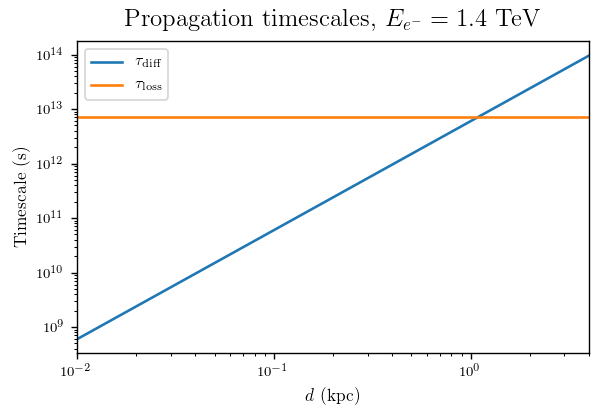

In [32]:
plt.figure(figsize=(5, 3.5))

ds = np.logspace(-2, np.log10(4), 400)

plt.plot(ds, t_diff(1400., ds), label=r"$\tau_{\mathrm{diff}}$")
plt.plot(ds, len(ds)*[t_loss(1400.)], label=r"$\tau_{\mathrm{loss}}$")

plt.title(r"Propagation timescales, $E_{e^-} = 1.4$ TeV")
plt.xlabel(r"$d$ (kpc)")
plt.ylabel("Timescale (s)")
plt.xlim(ds[[0, -1]])
plt.xscale("log")
plt.yscale("log")
plt.legend()

plt.tight_layout()
plt.savefig("../figures/propagation_timescales.pdf")

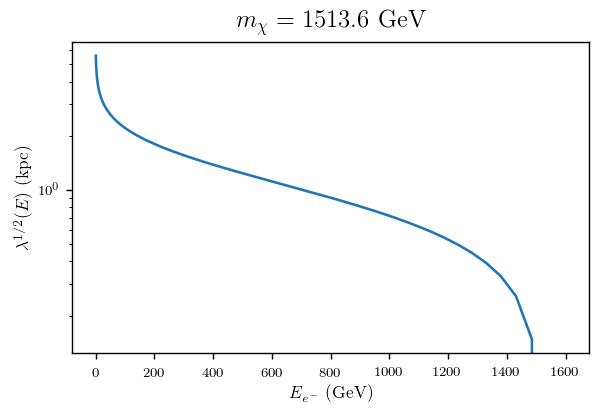

In [33]:
es = np.logspace(0, np.log10(1600), 200)

lambdas = lambda_prop(es, dampe_excess_bin_high)

plt.plot(es, np.sqrt(lambdas) / kpc_to_cm)

plt.yscale("log")
plt.xlabel(r"$E_{e^-}$ (GeV)")
plt.ylabel(r"$\lambda^{1/2}(E)$ (kpc)")
plt.title(r"$m_\chi = %.1f\mathrm{~GeV}$" % dampe_excess_bin_high)

plt.tight_layout()
plt.savefig("../figures/sqrt_lambda.pdf")

### Applying anisotropy and spectrum constraints

For DAMPE's background model:
* Taking $d > 1.17$ kpc is ruled out by anistropy bounds.
* Taking $d > 0.385$ kpc is ruled out by requiring that the DM + background contribution to the integrated flux does not exceed the observed value plus $3\sigma$. The background model is ruled out at the $2\sigma$ level...

For Ge et al's background model:
* Taking $d > 1.14$ kpc is ruled out by anistropy bounds.
* Taking $d > 0.474$ kpc is ruled out by requiring that the DM + background contribution to the integrated flux does not exceed the observed value plus $2\sigma$.
* Taking $d > 0.597$ kpc is ruled out by requiring that the DM + background contribution to the integrated flux does not exceed the observed value plus $3\sigma$.

In [130]:
ds = np.logspace(np.log10(0.01), np.log10(10), 300)

# Find max distance allowed by spectrum shape constraints
for d in ds:   
    c_spec = constrain_ep_e_spec_pt(d, bg_alt, excluded_idxs=range(23, 28) + [29])
    if not c_spec:
        d_max_spec_bg_alt = d
        break

# Find max distance allowed by anisotropy constraints
for d in ds:
    c_aniso = constrain_anisotropy_pt(d, bg_alt)
    if not c_aniso:
        d_max_aniso_bg_alt = d
        break

# Find max distance allowed by spectrum and anistropy constraints
d_max_bg_alt = min([d_max_aniso_bg_alt, d_max_spec_bg_alt])

KeyboardInterrupt: 

In [ ]:
ds = np.logspace(np.log10(0.01), np.log10(10), 300)

# Find max distance allowed by anisotropy constraints
for d in ds:
    c_aniso = constrain_anisotropy_pt(d, bg_dampe)
    if not c_aniso:
        d_max_aniso_bg_dampe = d
        break

# Find max distance allowed by spectrum shape constraints
for d in ds:   
    c_spec = constrain_ep_e_spec_pt(d, bg_dampe)
    if not c_spec:
        d_max_spec_bg_dampe = d
        break

# Find max distance allowed by spectrum and anistropy constraints
d_max_bg_dampe = min([d_max_aniso_bg_dampe, d_max_spec_bg_dampe])

### $\bar{\chi}\chi \to e^+ e^-$ spectrum

In general, setting $m_\chi$ at the upper energy limit of the bin with the excess minimizes the luminosity.

For $d \gtrsim 1.5$ kpc, $\mathcal{L}$ is minimized by taking $m_\chi$ quite large, due to energy losses.

#### Differential flux

In [ ]:
plt.figure(figsize=(5, 3.5))

e_es = np.logspace(np.log10(300), np.log10(2.5e3), 400)

power = 3

# Observations
plot_obs(dampe_bin_low, dampe_bin_high,
         dampe_es**power * dampe_dflux,
         dampe_es**power * dampe_dflux_err,
         label="DAMPE", alpha=0.3, lw=0.5, color="y")

excess_idxs = range(23, 28) + [29]
plot_obs(dampe_bin_low[excess_idxs], dampe_bin_high[excess_idxs],
         dampe_es[excess_idxs]**power * dampe_dflux[excess_idxs],
         dampe_es[excess_idxs]**power * dampe_dflux_err[excess_idxs],
         alpha=0.5, lw=0.5, color="g")

# plot_obs(ams_bin_low, ams_bin_high,
#          ams_es**power * ams_dflux,
#          ams_es**power * ams_dflux_err,
#          label="AMS-02", alpha=0.5, lw=0.5, color="y")

# DM e-+e+ spectra + bg
plt.plot(e_es,e_es**power * (2.*dphi_de_e_dampe_pt(e_es, d=0.2, bg_dflux=bg_dampe) + bg_dampe(e_es)),
         label=r"DM + bg, $d$=0.2 kpc")

plt.plot(e_es, e_es**power * (2.*dphi_de_e_dampe_pt(e_es, d=0.2, bg_dflux=bg_alt) + bg_alt(e_es)),
         label=r"DM + alt. bg, $d$=0.2 kpc")

plt.plot(e_es, e_es**power * (2.*dphi_de_e_dampe_pt(e_es, d=d_max_bg_dampe, bg_dflux=bg_dampe) + bg_dampe(e_es)),
         label=r"DM + bg, $d$=%.3f kpc" % d_max_bg_dampe)

plt.plot(e_es, e_es**power * (2.*dphi_de_e_dampe_pt(e_es, d=d_max_bg_alt, bg_dflux=bg_alt) + bg_alt(e_es)),
         label=r"DM + alt. bg, $d$=%.3f kpc" % d_max_bg_alt)

plt.title(r"$\bar{\chi}\chi\to e^+ e^-$ fit to DAMPE excess")
plt.xlabel(r"$E$ (GeV)")
plt.ylabel(r"$E^3 \frac{d\phi}{dE}|_{e^- + e^+}$ (GeV$^2$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$)")
plt.xscale("log")
plt.yscale("log")
plt.xlim(e_es[[0, -1]])
plt.ylim(4e-3, 5e-2)
plt.legend(loc="upper left")

plt.tight_layout()
plt.savefig("../figures/electron_positron_diff_fluxes.png")

#### Integrated flux

In [ ]:
def dm_bg_ifluxes(d, bg_dflux):
    # Compute integrated DM + bg flux in each of DAMPE's bins
    ifluxes = []

    for (bl, br), dflux, dflux_err in zip(dampe_bins, dampe_dflux, dampe_dflux_err):
        # Get flux from DM annihilations in the bin
        iflux = quad(lambda e: 2.*dphi_de_e_dampe_pt(e, d, bg_dflux) + bg_dflux(e), bl, br, epsabs=0.)[0]
        ifluxes.append(iflux)
        
    return np.array(ifluxes)

In [ ]:
ifluxes_bg_dampe = dm_bg_ifluxes(0.2, bg_dampe)
ifluxes_bg_alt = dm_bg_ifluxes(0.2, bg_alt)

In [ ]:
plt.figure(figsize=(5, 3.5))

mx = 1500.  # best-fit DM mass for DAMPE excess (arXiv:1712.02744)

e_es = np.logspace(np.log10(5e2), np.log10(6e3), 400)

power = 3

# Observations
plot_obs(dampe_bin_low, dampe_bin_high,
         dampe_es**power * dampe_dflux,
         dampe_es**power * 3.*dampe_dflux_err,
         label="DAMPE", alpha=0.5, lw=0.5, color="g")

plt.plot(dampe_es, dampe_es**power * ifluxes_bg_dampe / (dampe_bin_high - dampe_bin_low), '.', label=r"DM + bg, $d$=0.2 kpc", linewidth=1.)
plt.plot(dampe_es, dampe_es**power * ifluxes_bg_alt / (dampe_bin_high - dampe_bin_low), '.', label=r"DM + alt. bg, $d$=0.2 kpc", linewidth=1.)

plt.title(r"$\bar{\chi}\chi\to e^+ e^-$ fit to DAMPE excess")
plt.xlabel(r"$E$ (GeV)")
plt.ylabel(r"$E^3 \frac{d\phi}{dE}|_{e^- + e^+}$ (GeV$^2$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$)")
plt.xscale("log")
plt.yscale("log")
# plt.xlim(e_es[[0, -1]])
plt.xlim(400, 5000)
# plt.ylim(0, 5e-2)
# plt.ylim(1e-14, 2e-10)
plt.ylim(1e-3, 5e-2)
plt.legend(loc="lower left")

plt.tight_layout()
# plt.savefig("../figures/electron_positron_diff_fluxes.pdf")

### Photon spectrum constraints

#### Differential photon flux at $E_\gamma = 10$ GeV

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


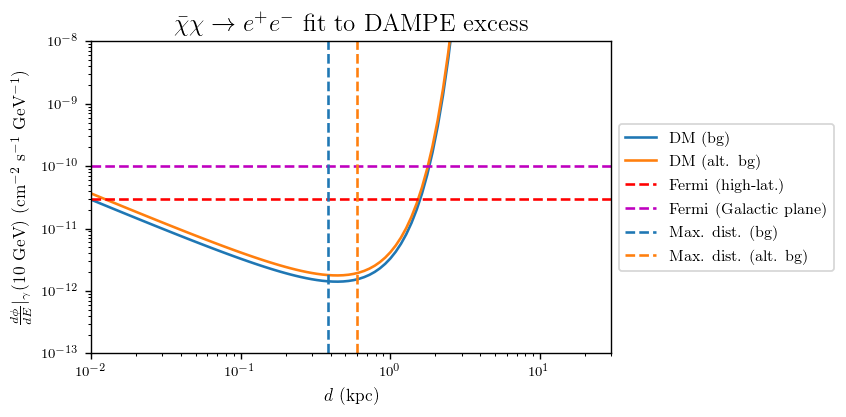

In [131]:
plt.figure(figsize=(6, 3.5))

ds = np.logspace(-2, np.log10(30), 100)

plt.plot(ds, [dphi_de_gamma_dampe_pt(10, d, bg_dampe) for d in ds], color=get_color("bg_dampe"), label="DM (bg)")
plt.plot(ds, [dphi_de_gamma_dampe_pt(10, d, bg_alt) for d in ds],
         color=get_color("bg_alt"), label="DM (alt. bg)")
# Plot Fermi point source sensitivity
plt.axhline(3e-11, color='r', linestyle='--', label="Fermi (high-lat.)")
plt.axhline(1e-10, color='m', linestyle='--', label="Fermi (Galactic plane)")
plt.axvline(0.385, linestyle='--', color=get_color("bg_dampe"),
            label="Max. dist. (bg)")
plt.axvline(0.597, linestyle='--', color=get_color("bg_alt"),
            label="Max. dist. (alt. bg)")

plt.title(r"$\bar{\chi}\chi\to e^+ e^-$ fit to DAMPE excess")
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$\frac{d\phi}{dE}|_\gamma(10~\mathrm{GeV})$ (cm$^{-2}$ s$^{-1}$ GeV$^{-1}$)")
plt.xlim(ds[[0, -1]])
plt.ylim([1e-13, 1e-8])
plt.xscale("log")
plt.yscale("log")

# Shrink current axis by 20%
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
# plt.savefig("../figures/dampe_ptlike_clump_photon_diff_flux.pdf")

#### Integrated photon flux

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


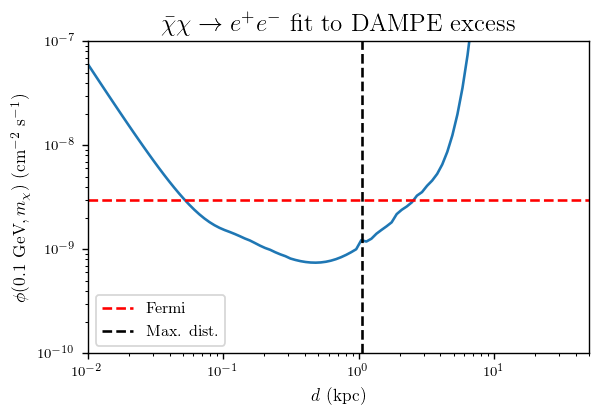

In [19]:
plt.figure(figsize=(5, 3.5))

ds = np.logspace(-2, np.log10(50), 100)

plt.plot(ds, [phi_gamma_dampe_pt(d) for d in ds])
# Plot Fermi point source sensitivity
plt.axhline(3e-9, color='r', linestyle='--', label="Fermi")
plt.axvline(1.06, linestyle='--', color='k', label="Max. dist.")

plt.title(r"$\bar{\chi}\chi\to e^+ e^-$ fit to DAMPE excess")
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$\phi(0.1~\mathrm{GeV}, m_\chi)$ (cm$^{-2}$ s$^{-1}$)")
plt.xlim(ds[[0, -1]])
plt.ylim([1e-10, 1e-7])
plt.xscale("log")
plt.yscale("log")
plt.legend()

plt.tight_layout()
plt.savefig("../figures/dampe_ptlike_clump_photon_flux.pdf")

### Anisotropy
This constraint is much weaker than the others.

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


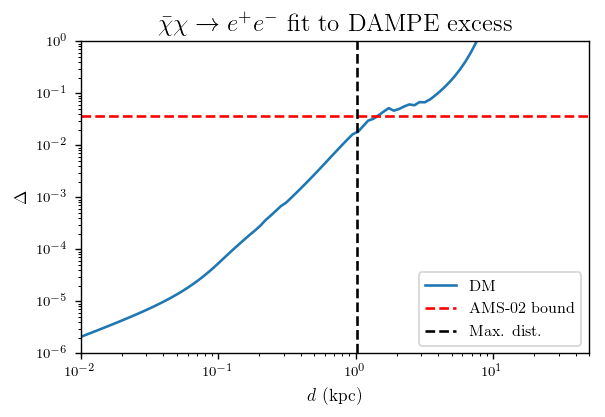

In [21]:
plt.figure(figsize=(5, 3.5))

ds = np.logspace(-2, np.log10(50), 100)

plt.plot(ds, [get_dampe_anisotropy_pt(d) for d in ds], label="DM")
plt.axhline(ams_aniso_bound, color='r', linestyle="--", label="AMS-02 bound")
plt.axvline(d_max, linestyle='--', color='k', label="Max. dist.")

plt.title(r"$\bar{\chi}\chi\to e^+ e^-$ fit to DAMPE excess")
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$\Delta$")
plt.xscale("log")
plt.yscale("log")
plt.xlim(ds[[0, -1]])
plt.ylim(1e-6, 1e0)
plt.legend()

plt.tight_layout()
plt.savefig("../figures/anisotropy.pdf")

### Best fit $m_\chi$ and $\mathcal{L}$

In [ ]:
ds = np.logspace(-2, np.log10(3), 100)

mxs_best = np.zeros(len(ds))
lums_best = np.zeros(len(ds))

for i, d in enumerate(ds):
    mxs_best[i], lums_best[i] = mx_lum_dampe_pt(d)

In [ ]:
plt.figure(figsize=(9, 3.5))

plt.subplot(1, 2, 1)
plt.loglog(ds, mxs_best)
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$m_\chi$ (GeV)")

plt.subplot(1, 2, 2)
plt.loglog(ds, lums_best)
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$\mathcal{L}$ (s$^{-1}$)")

## Results for finite clump

### $\bar{\chi}\chi \to e^+ e^-$ spectrum

In [135]:
# Dict for differential fluxes for finite clumps. Keys are:
#    Clump distance d (kpc)
#    Clump scale radius rs (kpc)
#    Background model (string)
finite_clump_dfluxes = {}

In [136]:
clump_params = [(0.01, 0.1, bg_dampe),
                (0.2, 0.1, bg_dampe)]

#### Differential flux

In [201]:
e_es = np.logspace(np.log10(8e2), np.log10(2e3), 300)

In [202]:
for d, rs, bg in clump_params:
    finite_clump_dfluxes[(d, rs, bg.__name__)] = dphi_de_e_dampe(e_es, d, rs, bg)

DAMPE's bg model. Using Ge et al's bg model simply changes the normalizations of the spectra.

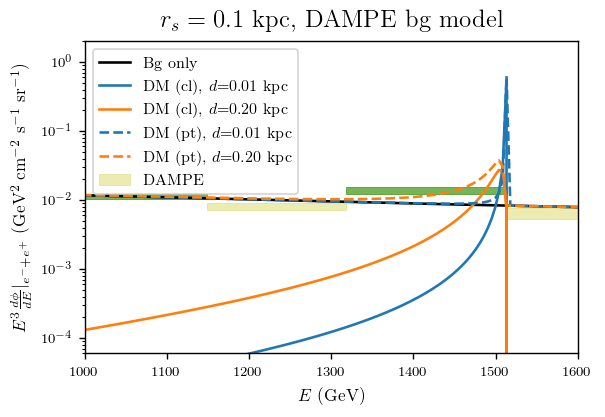

In [216]:
plt.figure(figsize=(5, 3.5))

power = 3

plot_obs(power)    
plt.plot(e_es, e_es**power * bg(e_es), 'k', label="Bg only")

# DM spec + bg, clump
for (d, rs, bg), c in zip(clump_params, colors):
    plt.plot(e_es, e_es**power * (2.*finite_clump_dfluxes[(d, rs, bg.__name__)]),
             label=r"DM (cl), $d$=%.2f kpc" % d, color=c)

# DM spec + bg, pointlike source
for (d, rs, bg), c in zip(clump_params, colors):
    plt.plot(e_es, e_es**power * (2.*dphi_de_e_dampe_pt(e_es, d, bg)),
             '--', label=r"DM (pt), $d$=%.2f kpc" % d, color=c)

plt.title(r"$r_s=0.1$ kpc, DAMPE bg model")
plt.xlabel(r"$E$ (GeV)")
plt.ylabel(y_label % (power, power-1))
plt.yscale("log")
plt.xlim(1e3, 1.6e3)
plt.ylim(6e-5, 2e0)
plt.legend(loc="upper left")

plt.tight_layout()
# plt.savefig("../figures/electron_positron_diff_fluxes_clump_vs_pt.png")

### Photon spectrum

In [ ]:
plt.figure(figsize=(6, 3.5))

ds = np.logspace(-2, np.log10(100), 2)

plt.plot(ds, [dphi_de_gamma_dampe(10, np.cos(np.pi), d, 0.01, bg_dampe) for d in ds],
         color=get_color("bg_dampe"), label="DM cl (bg)")
plt.plot(ds, [dphi_de_gamma_dampe_pt(10, d, bg_dampe) for d in ds], '--',
         color=get_color("bg_dampe"), label="DM pt (bg)")
# Plot Fermi point source sensitivity
plt.axhline(3e-11, color='r', linestyle='--', label="Fermi (high-lat.)")
plt.axhline(1e-10, color='m', linestyle='--', label="Fermi (Galactic plane)")

plt.title(r"$\bar{\chi}\chi\to e^+ e^-$ fit to DAMPE excess")
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$\frac{d\phi}{dE}|_\gamma(10~\mathrm{GeV})$ (cm$^{-2}$ s$^{-1}$ GeV$^{-1}$)")
plt.xlim(ds[[0, -1]])
plt.ylim([1e-13, 1e-8])
plt.xscale("log")
plt.yscale("log")

# Shrink current axis by 20%
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
# plt.savefig("../figures/dampe_ptlike_clump_photon_diff_flux.pdf")

### Clump profile density normalization
Can't make this in the pointlike case, obviously.

In [35]:
ds = np.logspace(-2, 0, 100)

In [36]:
rhos_bg_dampe = np.array([rhos_dampe(d, dampe_excess_bin_high, 0.1, bg_dampe) for d in ds])

In [37]:
rhos_bg_alt = np.array([rhos_dampe(d, dampe_excess_bin_high, 0.1, bg_alt) for d in ds])

NameError: name 'bg_altlt' is not defined

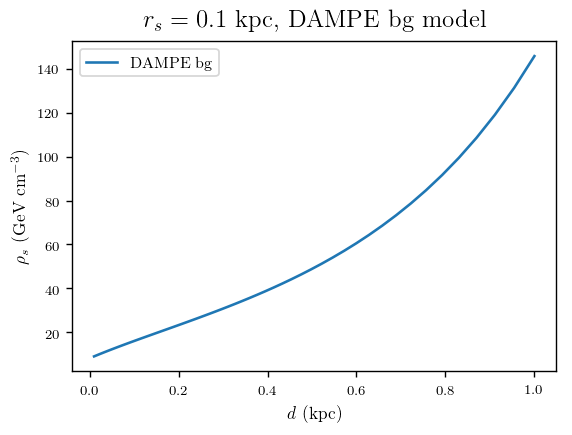

In [38]:
ds = np.logspace(-2, 0, 100)

plt.plot(ds, rhos_bg_dampe, label="DAMPE bg")
# plt.plot(ds, rhos_bg_alt, label="Ge et al bg")

plt.title(r"$r_s = 0.1$ kpc, DAMPE bg model")
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$\rho_s$ (GeV cm$^{-3}$)")
plt.legend()

# plt.savefig("../figures/clump_density_normalization.png")

In [ ]:
os.system("say 'Done'")